# Observing system simulation experiments

```mermaid
graph LR

    RM["`Reference
    model`"]
    NS(("`Model states`"))
    OM1["`Obs.
    system 1`"]
    OM2["`Obs.
    system 2`"]
    SO1(("`Simulated
    obs. 1`"))
    SO2(("`Simulated
    obs. 2`"))
    DA1["`Data 
    assim. 1`"]
    DA2["`Data
    assim. 2`"]
    ES1(("`Estimated
    states 1`"))
    ES2(("`Estimated
    states 2`"))
    OSC["`Obs. system
    comparison`"]

    RM --> NS
    NS --> OM1 --> SO1 --> DA1 --> ES1
    NS --> OM2 --> SO2 --> DA2 --> ES2
    ES1 --> OSC
    ES2 --> OSC
    NS --> OSC
```

This notebook explores an approach to defining a _observing system simulation experiment_ (OSSE).

At a high-level OSSEs allow comparing the informational value of different potential observation systems for a physical process.
This is done by _simulating observations_ from the states of a _reference model_ for the process under each of the different observation systems being considered.

A _probabilistic (or statistical) model_  for the process is then used to _estimate the process states given the simulation observations_. As in practice the observations are noisy and partial, their will be _uncertainty_ in the statistical estimates - we are inferring a distribution on the states given observations and model. Often for spatiotemporal models, this process of combining a model with observed data is termed _data assimilation_. 

Given the statistical estimates of the process state for each of the different observing systems, we can then compare the state estimates with the known true reference model states to evaluate how informative the observation system is about the process.

A flowchart of the overall OSSE workflow for the case where two observation systems are being compared is shown above.

Below we give an interactive example for a toy spatiotemporal reference model where the probabilistic model is chosen to be a Gaussian process. The choice of a Gaussian process makes the estimation step particularly tractable but more complex and informative models could be used instead, at the cost of a higher computational burden for fitting the model to observations.

The Gaussian process models are implemented using the [tinygp package](https://tinygp.readthedocs.io/en/stable/) which builds on top of the [high-performance array computing framework JAX](https://docs.jax.dev/en/latest/). The [jaxopt package](https://jaxopt.github.io/stable/) will be used to fit the parameters of the Gaussian process model to simulated observed data. We will use Matplotlib to visualize results and will end with an interactive visualization using the [ipywidgets package](https://ipywidgets.readthedocs.io/en/latest/index.html).

In [1]:
try:
    import google.colab
    !wget https://raw.githubusercontent.com/aria-verify/osse-demo/refs/heads/main/requirements.txt
    !pip install -r requirements.txt
except ImportError:
    pass

import jax
import jax.numpy as jnp
import jaxopt
import tinygp
import equinox as eqx
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets
from collections import defaultdict
from functools import partial

jax.config.update("jax_enable_x64", True)

## Reference model

As a reference model we will use assume we have an one dimensional spatial domain and that our spatialtemporal model is

$$f(t, x) = \sin(x) \cos(t + x) \cos(2x) \sin(t / 4)$$

This is intentionally a simple case for illustrative purposes. In practice this could be any numerical model for which we can simulate the model variables in time and space.

In [2]:
def reference_model(t, x):
    xp = x.__array_namespace__()
    return xp.sin(x) * xp.cos(t + x) + xp.cos(2 * x) * xp.sin(t / 4)

We define a helper function to evaluate this reference model at a grid of points in space and time. For some processes we may be interested in how much observation systems inform us about derivatives of the process state as well as or instead of the value. In this example we will assume the spatial derivative is of interest so compute this alongside the value, using JAX's automatic differentiation and batching support.

In [3]:
def compute_gridded_data(
    n_grid_time, n_grid_position, time_interval, position_interval
):
    times, positions = np.meshgrid(
        np.linspace(*time_interval, n_grid_time),
        np.linspace(*position_interval, n_grid_position),
    )
    values = reference_model(times, positions)
    spatial_derivatives = jax.vmap(jax.vmap(jax.grad(reference_model, argnums=1)))(
        times, positions
    )
    return {
        "times": times,
        "positions": positions,
        "values": values,
        "spatial_derivatives": spatial_derivatives,
    }

To allow for consistent labelling of plot axes we define a dictionary mapping from quantity keys to corresponding labels.

In [4]:
labels = {
    "times": r"Time $t$",
    "positions": r"Position $x$",
    "velocities": r"Velocity $\partial x(t)$",
    "values": r"Value $f(t, x)$",
    "spatial_derivatives": r"Spatial derivative $\partial_2 f(t, x)$",
    "trajectory_derivatives": r"Trajectory temporal derivative $\partial(t \mapsto f(t, x(t)))$",
}

We now define a further helper function to allow visualizing the gridded reference model data as pseudocolor maps.

In [5]:
def visualize_reference_model(gridded_data, fig_axes=None):
    if fig_axes is None:
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    else:
        fig, axes = fig_axes
    for ax, key in zip(axes, ("values", "spatial_derivatives")):
        ax.pcolormesh(
            gridded_data["times"],
            gridded_data["positions"],
            gridded_data[key],
            shading="gouraud",
        )
        ax.set(xlabel=labels["times"], ylabel=labels["positions"], title=labels[key])
    if fig_axes is None:
        fig.tight_layout()
        return fig, axes

Using the helper functions we have just defined, we can now generate reference model data over a grid in time and space and visualize the resulting fields.

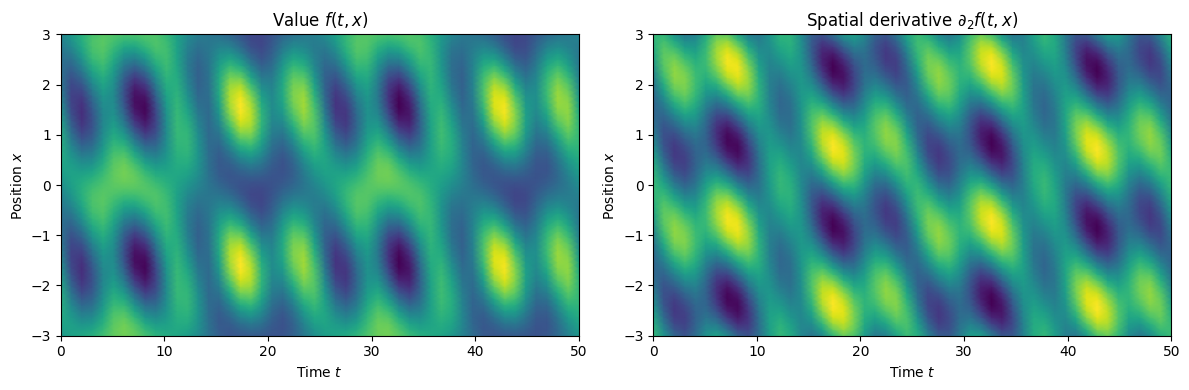

In [6]:
gridded_data = compute_gridded_data(
    n_grid_time=50, n_grid_position=50, time_interval=(0, 50), position_interval=(-3, 3)
)
_ = visualize_reference_model(gridded_data)

## Observation system model

A key component of any OSSE are models of the observing systems to be compared. Here we assume the process is observed by a sensor which moves over time. In particular the sensor position is assumed to oscillate back and forth around the origin, subject to stochastic peturbations. At regular time steps the process value and/or the rate of change of the process value along the sensor trajectory is noisily measured. 

We use a simple dampled stochastic harmonic oscillator model for the sensor trajectory

$$\mathrm{d}x(t) = v \, \mathrm{d} t, \mathrm{d}v(t) = (-x(t) / m) \, \mathrm{dt} + \sigma_t \, \mathrm{d}w(t)$$

where $t$ is the time coordinate , $x$ is the sensor position, $v$ the sensor velocity, $m$ the sensor mass, $w$ is a Wiener noise process and $\sigma_t$ a non-negative noise scale parameter, which we simulate using a leapfrog integrator.

In [7]:
def simulate_trajectory(rng, dt, n_step, noise_scale, mass):
    ts, xs, vs = np.full((3, n_step), np.nan)
    ts[0], xs[0], vs[0] = 0, rng.standard_normal(), rng.standard_normal() / mass**0.5
    noise_std = noise_scale * dt**0.5
    for s in range(1, n_step):
        ts[s] = ts[s - 1] + dt
        x_half = xs[s - 1] + dt * vs[s - 1] / 2
        vs[s] = (1 - noise_std**2) ** 0.5 * (
            vs[s - 1] - x_half * dt / mass
        ) + noise_std * rng.standard_normal() / mass
        xs[s] = x_half + dt * vs[s] / 2
    return ts, xs, vs

The observed values and derivatives are assumed to be subject to independent Gaussian noise of differing scales.

Specifically the observations of the value are modelled as

$$y^v_n \sim \mathsf{Normal}(f(t_n, x(t_n), \sigma_v)$$

where $y^v_n$ is the noisy observation of the value at measurement time $t_n$ and position $x(t_n)$ and $\sigma_v$ is a parameter controlling the amount of noise in the observations.

For the observations of the derivative, we use the chain rule to expand the temporal derivative along the sensor trajectory as

$$ \partial(t \mapsto f(t, x(t))) = \partial_1 f(t, x(t)) + \partial_2 f(t, x(t)) \partial x(t) = \partial_1 f(t, x(t)) + \partial_2 f(t, x(t)) v(t)$$

with the derivative observations then modelled as

$$y^d_n \sim \mathsf{Normal}(\partial_1 f(t_n, x(t_n)) + \partial_2 f(t_n, x(t_n)) v(t_n), \sigma_d)$$

where $y^d_n$ is the noisy observation of the derivative at measurement time $t_n$, position $x(t_n)$ and velocity $v(t_n)$ and $\sigma_d$ is a parameter controlling the amount of noise in the observations.

Here we assume the sensor positions and velocities at each measurement time are known exactly. This could be relaxed to instead allow for the measured positions and velocities being subject to some noise, with the sensor state (position and velocity) then jointly estimated along with the process state given the observed data.

To allow for comparing the informational content of observing the value and derivatives and how the information available depends on the noise scales and sensor trajectories, we define a function which maps from the parameters we may wish to compare across to simulated observed data.

In [8]:
def simulate_observed_data(
    rng,
    value,
    derivative,
    dt,
    n_observation_time,
    trajectory_noise_scale,
    value_noise_scale,
    derivative_noise_scale,
    mass,
):
    times, positions, velocities = simulate_trajectory(
        rng, dt, n_observation_time, trajectory_noise_scale, mass
    )
    values = reference_model(times, positions)
    observed_values = (
        values + value_noise_scale * rng.standard_normal(times.shape) if value else None
    )
    df_dt, df_dx = jax.vmap(jax.grad(reference_model, (0, 1)))(times, positions)
    trajectory_derivatives = df_dt + df_dx * velocities
    observed_trajectory_derivatives = (
        trajectory_derivatives
        + derivative_noise_scale * rng.standard_normal(times.shape)
        if derivative
        else None
    )
    return {
        "times": times,
        "positions": positions,
        "velocities": velocities,
        "values": values,
        "trajectory_derivatives": trajectory_derivatives,
        "observed_values": observed_values,
        "observed_trajectory_derivatives": observed_trajectory_derivatives,
    }

We define a further helper function to allow visualizing the simulated observation data (sensor positions, velocities, measured values and derivatives across time).

In [9]:
def visualize_simulated_observations(observed_data, fig_axes=None):
    if fig_axes is None:
        fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    else:
        fig, axes = fig_axes
    for ax, key in zip(
        axes.flatten(),
        ("positions", "values", "velocities", "trajectory_derivatives"),
    ):
        ax.plot(observed_data["times"], observed_data[key], ".:", label="True value")
        observed_key = f"observed_{key}"
        if observed_data.get(observed_key) is not None:
            ax.plot(
                observed_data["times"],
                observed_data[observed_key],
                ".",
                label="Noisy observation",
            )
            ax.legend(frameon=False)
        ax.set(xlabel=labels["times"], ylabel=labels[key])
    if fig_axes is None:
        fig.tight_layout()
        return fig, axes

We now simulate a set of observed data, seeding a random number generator for reproducibility, and visualize it using the functions just defined. For now we assume that we observed both values and derivatives.

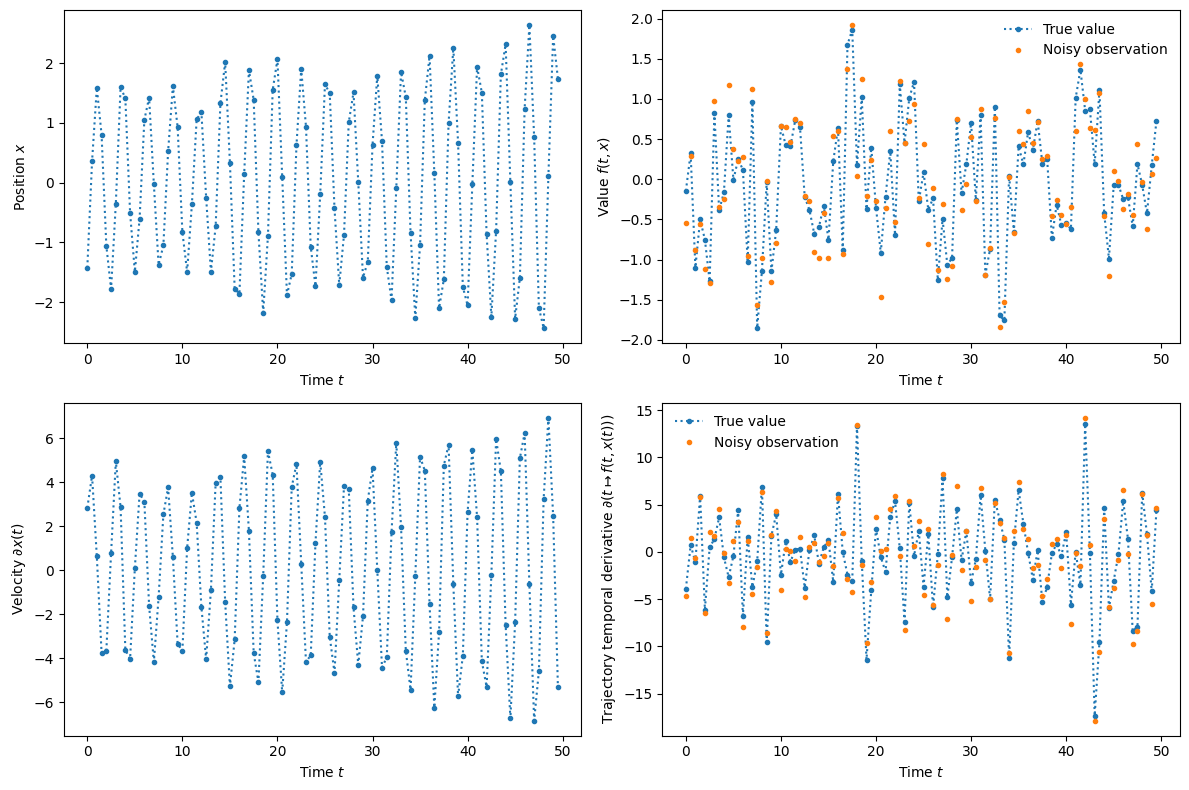

In [10]:
seed = 12345
value = True
derivative = True
rng = np.random.default_rng(seed)
observed_data = simulate_observed_data(
    rng,
    value=value,
    derivative=derivative,
    dt=0.5,
    n_observation_time=100,
    trajectory_noise_scale=0.1,
    value_noise_scale=0.2,
    derivative_noise_scale=1.0,
    mass=0.2,
)
_ = visualize_simulated_observations(observed_data)

## Probabilistic model

Now that we have simulated observed data, we need to estimate what this observed data tells us about the state of the reference model. This requires us to have a probabilistic model which allows us to express our assumptions about the observed data and model states.

In some cases the reference model may have free parameters that can be assumed unknown, or stochastic dynamics, such that it could be in combination with the observation model as the basis of the probabilistic model used for inferring the state given observations. While this will in some sense maximise the information we can infer from our simulated observation, in most applications of interest we will not have an exact model for the true process of interest. Further the numerical model we use for our reference model may be very computationally costly, meaning iteratively running it as part of a iteartive state estimation algorithm may not be tractable.

Here we a tractable but powerful probabilistic model for functions - a Gaussian process - which allows use to represent assumptions about high-level properties of the process (for example smoothness, typical lengthscales). The fundamental assumption of a Gaussian process is the values of the process at any set of indices (here spatial-temporal coordinates) are jointly Gaussian distributed. A Gaussian process prior on a unknown spatiotemporal process $\tilde{f}$ can be specified in terms of a mean function $m$ and covariance function (kernel) $k$,

$$ \tilde{f} \sim \mathsf{GaussianProcess}(m, k) $$

which are defined such that

$$ \mathbb{E}[\tilde{f}(t, x)] = m(t, x), \quad \mathbb{C}[\tilde{f}(t, x), \tilde{f}(t', x')] = \mathbb{E}[(\tilde{f}(t, x) - \mathbb{E}[\tilde{f}(t, x)])(\tilde{f}(t', x') - \mathbb{E}[\tilde{f}(t', x')])] = k((t, x), (t', x'))$$

for any pairs of time and space coordinates $(t, x)$ and $(t', x')$.

For a Gaussian process which is conditioned on observed data from a linear-Gaussian observation model, the posterior distribution on the process given the observations is another Gaussian process.

For our observation model, an added benefit of assuming a Gaussian process model for the state is that derivatives of a Gaussian process are themselves another Gaussian process:

$$ \mathbb{E}[\partial_i \tilde{f}(t, x)] = \partial_i m(t, x), \quad \mathbb{C}[\partial_i \tilde{f}(t, x), \partial_j \tilde{f}(t', x')] = \partial_{1,i} \partial_{2,j} k((t, x), (t', x')), \quad \mathbb{C}[\partial_i \tilde{f}(t, x), \tilde{f}(t', x')] = \partial_{1,i} k((t, x), (t', x'))$$

This means we can condition on observations of both the value and derivatives of the process without any need to approximate derivatives using numerical finite difference approaches.

Here we will use the tinygp package to implement our Gaussian process model. We have adapted code from tutorial examples on [derivative observations](https://tinygp.readthedocs.io/en/stable/tutorials/derivative.html) and [multivariate processes](https://tinygp.readthedocs.io/en/stable/tutorials/multivariate.html) for our use case.

We first define a kernel class to allow for conditioning on values and/or derivatives of the process. This uses JAX's automatic differentiation support to compute the necessary derivatives of a base kernel function. The input coordinates are assumed to be tuples with the first element the coordinate(s) to evaluate the process at and the second element either a non-zero vector specifying the direction along which the derivative is to be evaluated, or a zero-vector if the value rather than derivative is to be evaluated.


In [11]:
class ValueAndDerivativeKernel(tinygp.kernels.Kernel):
    kernel: tinygp.kernels.Kernel
    value: bool = eqx.field(static=True, default=True)
    derivative: bool = eqx.field(static=True, default=True)

    def evaluate(self, inputs_1, inputs_2):
        x_1, v_1 = inputs_1
        x_2, v_2 = inputs_2

        if not self.value and not self.derivative:
            raise ValueError("At least one of value or derivative must be True")

        if self.value and not self.derivative:
            return self.kernel.evaluate(x_1, x_2)

        (k, dk_1), (dk_2, d2k_1_2) = jax.jvp(
            lambda x_2_: jax.jvp(
                lambda x_1_: self.kernel.evaluate(x_1_, x_2_), (x_1,), (v_1,)
            ),
            (x_2,),
            (v_2,),
        )

        if self.derivative and not self.value:
            return d2k_1_2

        is_grad_obs_1 = ~jnp.all(v_1 == 0)
        is_grad_obs_2 = ~jnp.all(v_2 == 0)

        return jnp.where(
            is_grad_obs_1,
            jnp.where(is_grad_obs_2, d2k_1_2, dk_1),
            jnp.where(is_grad_obs_2, dk_2, k),
        )

We then define helper functions to massage our simulated data in to the format required by our tinygp `ValueAndDerivativeKernel`

In [12]:
def prepare_gaussian_process_inputs(data, value, derivative):
    xp = data["times"].__array_namespace__()
    n_input = data["times"].size
    times_positions = xp.stack(
        (data["times"].flatten(), data["positions"].flatten()), axis=-1
    )
    # If data includes velocities assume derivative values along velocity direction
    # otherwise derivatives are along position coordinate
    if "velocities" in data:
        derivative_directions = xp.stack(
            (xp.ones(n_input), data["velocities"].flatten()), axis=-1
        )
    else:
        derivative_directions = xp.stack((xp.zeros(n_input), xp.ones(n_input)), axis=-1)
    value_directions = xp.zeros_like(derivative_directions)
    if value and derivative:
        return (
            xp.concatenate((times_positions, times_positions)),
            xp.concatenate((value_directions, derivative_directions)),
        )
    elif value:
        return (times_positions, value_directions)
    elif derivative:
        return (times_positions, derivative_directions)
    else:
        raise ValueError("At least one of value and derivative must be True")


def prepare_gaussian_process_outputs(data):
    xp = data["times"].__array_namespace__()
    if (
        data["observed_values"] is not None
        and data["observed_trajectory_derivatives"] is not None
    ):
        return xp.concatenate(
            (
                data["observed_values"].flatten(),
                data["observed_trajectory_derivatives"].flatten(),
            )
        )
    elif data["observed_values"] is not None:
        return data["observed_values"].flatten()
    elif data["observed_trajectory_derivatives"] is not None:
        return data["observed_trajectory_derivatives"].flatten()
    else:
        raise ValueError(
            "At least one of observed_values and observed_derivatives in data must not be None"
        )

We now have the elements required to build a Gaussian process model for our system. As our base kernel, here we use an exponential squared (radial basis function) kernel with learnable parameters specifying the amplitude and a decorrelating / scale normalising linear transform in the coordinate space. The value and derivative observations are assumed to be independent with additive Gaussian noise with unknown scales (which depends on the observation types). This matches the simulated observation model used, but with the scales left as unknown. 

In [13]:
@partial(jax.jit, static_argnames=("value", "derivative"))
def build_gaussian_process(parameters, inputs, value, derivative):
    base_kernel = parameters["amplitude"] * tinygp.transforms.Cholesky.from_parameters(
        parameters["length_scales"],
        parameters["correlation"],
        tinygp.kernels.ExpSquared(),
    )
    kernel = ValueAndDerivativeKernel(base_kernel, value, derivative)
    if value and derivative:
        is_deriv_obs = ~jnp.all(inputs[1] == 0, axis=-1)
        diagonal = jnp.where(
            is_deriv_obs,
            parameters["derivative_noise_scale"] ** 2,
            parameters["value_noise_scale"] ** 2,
        )
    elif value and not derivative:
        diagonal = parameters["value_noise_scale"] ** 2
    elif derivative and not value:
        diagonal = parameters["derivative_noise_scale"] ** 2
    else:
        raise ValueError("One of value or derivative must be True")
    return tinygp.GaussianProcess(kernel, inputs, diag=diagonal)

We specify a simple prior distribution on the parameters, using independent log normal distributions on the non-negative parameters and normal distributions on the unconstrained parameters. This is formulated as a transformation from an unconstrained standard normal distributed vector to simplify fitting the parameters.

In [14]:
def generate_parameters(u):
    return {
        "amplitude": jnp.exp(u[0]),
        "length_scales": jnp.exp(u[1:3]),
        "correlation": u[3],
        "value_noise_scale": jnp.exp(u[4]),
        "derivative_noise_scale": jnp.exp(u[5]),
    }


generate_parameters.input_dimension = 6

Here will simply fit the model parameters by maximising the marginal posterior probability given the observed data using an optimizer from `jaxopt`, using tinygp's built in support for evaluating the marginal log probability of observed outputs under a Gaussian process prior. In practice we might want to instead to approximate the posterior distribution on the parameters using for example a Markov chain Monte Carlo method or variational inference.

In [15]:
def fit_gaussian_process(inputs, outputs, seed, value, derivative):
    @jax.jit
    def loss(u):
        parameters = generate_parameters(u)
        gaussian_process = build_gaussian_process(parameters, inputs, value, derivative)
        return -gaussian_process.log_probability(outputs) + (u**2).sum() / 2

    rng_key = jax.random.key(seed)
    u_init = jax.random.normal(rng_key, generate_parameters.input_dimension)
    optimizer = jaxopt.ScipyMinimize(fun=loss)
    solution = optimizer.run(u_init)
    parameters = generate_parameters(solution.params)
    return parameters

Given a Gaussian process object and fitted parameters we can use tinygp's support for automatically computing the Gaussian process corresponding to conditioning the original Gaussian process on observed outputs, to compute the predicted distribution on the value and spatial derivatives of the conditioned process at new inputs.

In [16]:
@jax.jit
def compute_gausian_process_predictions(
    gaussian_process, conditioning_outputs, prediction_data, seed
):
    predictions = defaultdict(dict)
    rng_key = jax.random.key(seed)
    for key in ("values", "spatial_derivatives"):
        inputs = prepare_gaussian_process_inputs(
            prediction_data,
            value=key == "values",
            derivative=key == "spatial_derivatives",
        )
        conditioned_gaussian_process = gaussian_process.condition(
            conditioning_outputs, inputs
        ).gp
        predictions["mean"][key] = conditioned_gaussian_process.mean
        predictions["variance"][key] = conditioned_gaussian_process.variance
        predictions["sample"][key] = conditioned_gaussian_process.sample(rng_key)
    return predictions

Finally we define a function to visualize the Gaussian process estimates of the process value and spatial derivative, showing the mean and variance of the predictions and optionally a sampled realisation from the Gaussian process.

In [17]:
def visualize_predictions(predictions, gridded_data, fig_axes=None, show_samples=False):
    statistics = ("mean", "variance")
    if show_samples:
        statistics += ("sample",)
    if fig_axes is None:
        fig, axes = plt.subplots(2, len(statistics), figsize=(4 * len(statistics), 8))
    else:
        fig, axes = fig_axes
    for ax_col, key in zip(axes, ("values", "spatial_derivatives")):
        for ax, statistic in zip(ax_col, statistics):
            ax.pcolormesh(
                gridded_data["times"],
                gridded_data["positions"],
                predictions[statistic][key].reshape(gridded_data["times"].shape),
                shading="gouraud",
            )
            ax.set(
                xlabel=labels["times"],
                ylabel=labels["positions"],
                title=f"{labels[key]} {statistic}",
            )
    if fig_axes is None:
        fig.tight_layout()
        return fig, axes

We now have the elements needed to fit a Gaussian process to our simulated observed data and visualize the resulting state estimates:

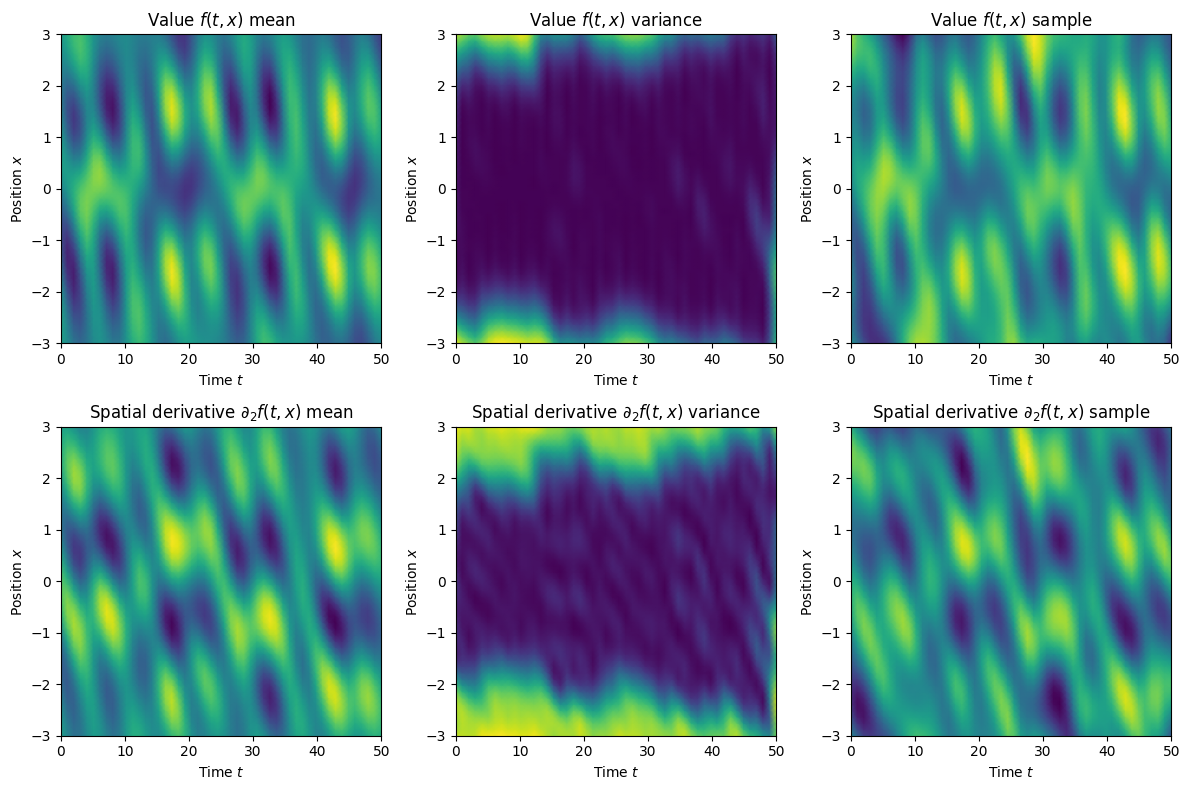

In [18]:
inputs = prepare_gaussian_process_inputs(observed_data, value, derivative)
outputs = prepare_gaussian_process_outputs(observed_data)
parameters = fit_gaussian_process(inputs, outputs, seed, value, derivative)
fitted_gaussian_process = build_gaussian_process(
    parameters, inputs, value=True, derivative=True
)
predictions = compute_gausian_process_predictions(
    fitted_gaussian_process, outputs, gridded_data, seed
)
_ = visualize_predictions(predictions, gridded_data, show_samples=True)

Given our (distributional) state estimates we may also wish to compute summary statistics to allow assessing how informative the observations are about different aspects of the reference model. One possible metric of interest is the expected _mean squared error_ (MSE) across a grid of space-time points between the estimated and (true) reference model state values. This can expanded in terms of the estimated state mean and variance (given observations) as

$$ \mathbb{E}\left[\frac{1}{M}\sum_{m=1}^M(\tilde{f}(t_m, x_m) - f(t_m, x_m))^2 \mid y^{d,v}_{1:N} \right] = \frac{1}{M}\sum_{m=1}^M \left( \left(\mathbb{E}\left[\tilde{f}(t_m, x_m) \mid y^{d,v}_{1:N} \right] - f(t_m, x_m) \right)^2 + \mathbb{V}\left[\tilde{f}(t_m, x_m) \mid y^{d,v}_{1:N} \right] \right)$$

with an analogous definition for the spatial derivatives of the state. This can then be implemented in Python as follows.

In [19]:
def compute_expected_mse(predictions, gridded_data):
    return {
        key: (
            (gridded_data[key].flatten() - predictions["mean"][key]) ** 2
            + predictions["variance"][key]
        ).mean()
        for key in ("values", "spatial_derivatives")
    }

We can then apply this function to compute the expected MSE in the state value and spatial derivatives under our Gaussian process posterior on the state given observations.

In [20]:
expected_mse = compute_expected_mse(predictions, gridded_data)
for key, value in expected_mse.items():
    print(f"Expected MSE of {key} = {value:.2f}")

Expected MSE of values = 0.21
Expected MSE of spatial_derivatives = 0.45


## Putting it all together

In the above sections we visualized the steps in one path through the OSSE workflow illustrated in the introduction, for a single observation system. In practice though we want to be able to compare different observation systems - for example how observing values or derivatives compares, or what the effect of differing scales of noise in the observations is. Below we create an interactive visualization that allows the parameters of the observing system to be controlled with a series of widgets and the resulting simulated observations, model estimates and metrics shown.

In [21]:
def visualize_results(gridded_data, observed_data, predictions, expected_mse):
    fig, axes = plt.subplots(2, 5, figsize=(20, 8), dpi=100)
    visualize_reference_model(gridded_data, (fig, axes[:, 0]))
    visualize_simulated_observations(observed_data, (fig, axes[:, 1:3].flatten()))
    visualize_predictions(predictions, gridded_data, (fig, axes[:, 3:]))
    for text, position, rotation in [
        ("Reference model", (0.11, 1), 0),
        ("Simulated observations", (0.41, 1), 0),
        ("Statistical model estimates given observations", (0.81, 1), 0),
        (f"Expected MSE = {expected_mse['values']:.2f}", (1, 0.75), 270),
        (f"Expected MSE = {expected_mse['spatial_derivatives']:.2f}", (1, 0.25), 270),
    ]:
        fig.text(*position, text, ha="center", va="center", size=14, rotation=rotation)
    fig.tight_layout()
    return fig, axes

In [22]:
def osse_workflow(
    seed,
    value,
    derivative,
    trajectory_noise_scale,
    value_noise_scale,
    derivative_noise_scale,
    mass,
    dt,
    n_observation_time,
    n_grid_position,
    n_grid_time,
):
    rng = np.random.default_rng(seed)
    observed_data = simulate_observed_data(
        rng,
        value,
        derivative,
        dt,
        n_observation_time,
        trajectory_noise_scale,
        value_noise_scale,
        derivative_noise_scale,
        mass,
    )
    inputs = prepare_gaussian_process_inputs(observed_data, value, derivative)
    outputs = prepare_gaussian_process_outputs(observed_data)
    parameters = fit_gaussian_process(inputs, outputs, seed, value, derivative)
    fitted_gaussian_process = build_gaussian_process(
        parameters, inputs, value=True, derivative=True
    )
    gridded_data = compute_gridded_data(
        n_grid_time, n_grid_position, (0, dt * n_observation_time), (-3, 3)
    )
    predictions = compute_gausian_process_predictions(
        fitted_gaussian_process, outputs, gridded_data, seed
    )
    expected_mse = compute_expected_mse(predictions, gridded_data)
    fig, ax = visualize_results(gridded_data, observed_data, predictions, expected_mse)
    return fig

In [23]:
control_layout = ipywidgets.Layout(width="250px")
widget = ipywidgets.interactive(
    osse_workflow,
    {"manual": True, "manual_name": "Run"},
    seed=ipywidgets.IntText(
        12345, min=0, description="Random seed", layout=control_layout
    ),
    value=ipywidgets.Checkbox(True, description="Observe value", layout=control_layout),
    derivative=ipywidgets.Checkbox(
        True, description="Observe derivative", layout=control_layout
    ),
    trajectory_noise_scale=ipywidgets.FloatSlider(
        0.1,
        min=0.00,
        max=1.0,
        step=0.05,
        description="Traj. noise",
        layout=control_layout,
    ),
    value_noise_scale=ipywidgets.FloatSlider(
        0.2,
        min=0.05,
        max=2.0,
        step=0.05,
        description="Value noise",
        layout=control_layout,
    ),
    derivative_noise_scale=ipywidgets.FloatSlider(
        1.0,
        min=0.05,
        max=2.0,
        step=0.05,
        description="Deriv. noise",
        layout=control_layout,
    ),
    mass=ipywidgets.FloatSlider(
        0.2, min=0.1, max=1.0, step=0.1, description="Mass", layout=control_layout
    ),
    dt=ipywidgets.FloatSlider(
        0.5,
        min=0.1,
        max=1.0,
        step=0.1,
        description="Obs. timestep",
        layout=control_layout,
    ),
    n_observation_time=ipywidgets.IntText(
        100, min=1, width=0.1, description="Obs. times", layout=control_layout
    ),
    n_grid_position=ipywidgets.fixed(50),
    n_grid_time=ipywidgets.fixed(50),
)
controls = ipywidgets.HBox(
    widget.children[:-1], layout=ipywidgets.Layout(flex_flow="row wrap")
)
output = widget.children[-1]
display(ipywidgets.VBox([controls, output]))